<a href="https://colab.research.google.com/github/pockerman/hidden_markov_modeling/blob/master/stories/story_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Story 53


Chromosome 13


Apply ```HMM_Model_9.json``` in regions: 

* [R1: ```region_0_REGION_1_CHR_13_MEAN_CUTOFF.txt```,  1000000-20000000](#r1)
* [R2: ```region_0_REGION_2_CHR_13_MEAN_CUTOFF.txt```,  20000000-30000000](#r2) 
* [R3: ```region_0_REGION_3_CHR_13_MEAN_CUTOFF.txt```,  40000000-60000000](#r3)
* [R4: ```region_0_REGION_4_CHR_13_MEAN_CUTOFF.txt```,  60000000-80000000](#r4)
* [R5: ```region_0_REGION_5_CHR_13_MEAN_CUTOFF.txt```,  80000000-100000000](#r5)
* [R6: ```region_0_REGION_6_CHR_13_MEAN_CUTOFF.txt```,  100000000-114000000](#r6)


In [1]:
import sys
sys.path.append("../")

In [2]:
import numpy as np
from pomegranate import *
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from helpers import read_configuration_file, INFO, WARNING
from hmm_helpers import build_hmm
from helpers import WindowType
from preprocess_utils import get_distributions_list_from_names as get_dist_list
from region import Region

In [4]:
from notebooks_helpers import filter_viterbi_path
from notebooks_helpers import save_segments
from notebooks_helpers import load_data_file
from notebooks_helpers import get_start_end_segment
from notebooks_helpers import make_data_array
from notebooks_helpers import gmm_clustering
from notebooks_helpers import create_viterbi_path
from notebooks_helpers import create_states
from notebooks_helpers import create_tuf_state
from notebooks_helpers import get_states_counter
from notebooks_helpers import plot_hmm_states_to_labels
from notebooks_helpers import plot_hmm_label_state
from notebooks_helpers import plot_hmm_cluster_contours

In [5]:
sns.set(color_codes=True)

Orphan state HMM_Model-start removed due to no edges                             leading to it
Orphan state HMM_Model-end removed due to no edges                             leading to it


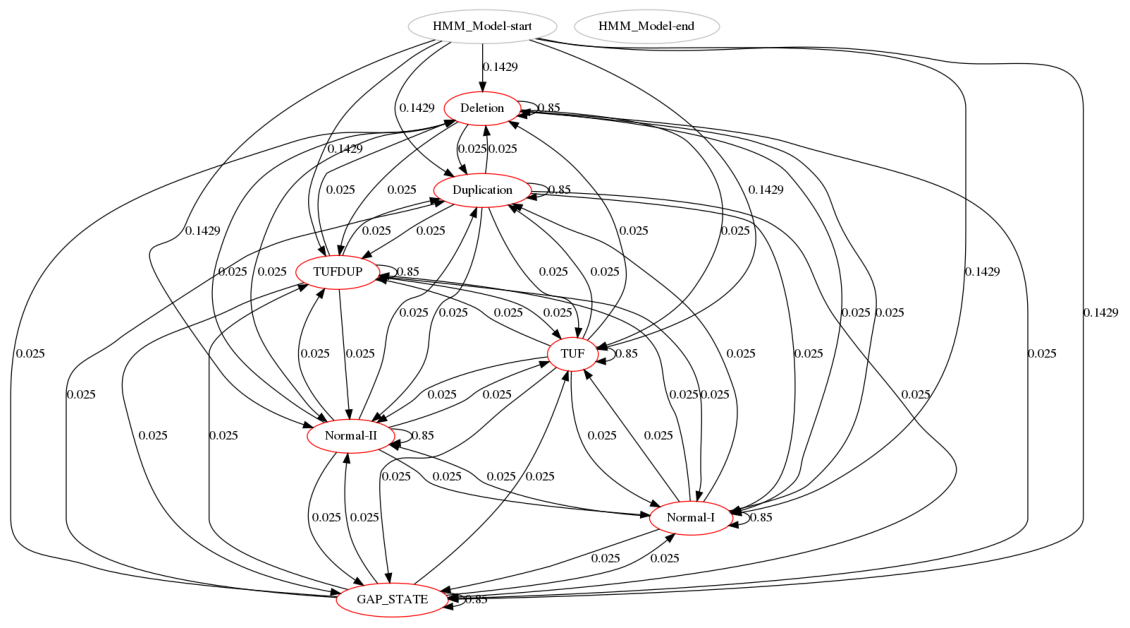

In [6]:
# load the configuration
configuration = read_configuration_file("../config.json")
hmm_config = configuration["HMM"]
hmm_filename = "HMM_Model_9.json"
hmm_model = build_hmm(hmm_file=hmm_filename)
# visualize the model we just trained
plt.figure( figsize=(20,18) )
hmm_model.plot()
plt.show()

## <a name="r1"></a>  Region 1

In [7]:
chr='chr13'
viterbi_paths = 'viterbi_paths_chr13/'


In [8]:
# load the region we want to use for prediction
region_name = "region_0_REGION_1_CHR_13_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_1_CHR_13_MEAN_CUTOFF.txt
Sequence length:  185206


In [9]:
filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model,
                                                                         chr=chr,
                                                                         filename=filename)

Observation length:  185206
Done. Execution time 0.5644739649997064 secs
Log-probability of ML Viterbi path:  -293464.3904877869
Viterbi path length:  185207
There should be 151726 gaps


In [10]:
# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

Length of path  185206
Length of TUF+DELETION+TUF state:  4335


In [11]:
wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

Length of WGA Observations:  33480
Encountered gaps:  151726


In [12]:
states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

{'Duplication': 2764, 'Normal-I': 14290, 'Normal-II': 2529, 'Deletion': 1403, 'Single-Deletion': 0, 'TUF': 9496, 'GAP_STATE': 151726, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 2998}


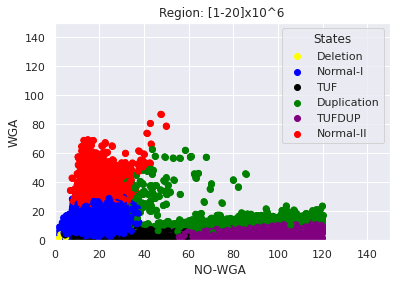

HMM labels color:  {'yellow': [3, 1403], 'blue': [1, 14290], 'black': [5, 9496], 'green': [0, 2764], 'purple': [6, 2998], 'red': [2, 2529]}


In [13]:
hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs,
                          title="Region: [1-20]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

In [14]:
for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

State:  Duplication
WGA mean/var:  10.35972503617945 38.47963017041516
NO-WGA mean/var:  73.00918596237337 487.39859112460755
State:  Normal-I
WGA mean/var:  14.693752974107769 26.839066817914528
NO-WGA mean/var:  18.251890832750178 24.4174951651294
State:  Normal-II
WGA mean/var:  31.451692368525105 69.17699650322766
NO-WGA mean/var:  20.02821273230526 26.355523654230925
State:  Deletion
WGA mean/var:  0.24483962936564505 0.23996082602751767
NO-WGA mean/var:  1.5431789023521025 1.9882851190987239
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.097126158382477 2.697793752407567
NO-WGA mean/var:  24.034572451558553 212.18208979192855
State:  GAP_STATE
WGA mean/var:  -999.0 0.0
NO-WGA mean/var:  -999.0 0.0
State:  GAP_STATE_INCORRECT
State:  TUFDUP
WGA mean/var:  5.191070713809207 5.573629974319103
NO-WGA mean/var:  84.94728819212807 340.89669221247567


## <a name="r2"></a> Region 2

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_2_CHR_13_MEAN_CUTOFF.txt
Sequence length:  199998
Observation length:  199998
Done. Execution time 0.9270899619987176 secs
Log-probability of ML Viterbi path:  -1340595.323819887
Viterbi path length:  199999
There should be 0 gaps
Length of path  199998
Length of TUF+DELETION+TUF state:  106
Length of WGA Observations:  199998
Encountered gaps:  0
{'Duplication': 119, 'Normal-I': 152956, 'Normal-II': 45769, 'Deletion': 117, 'Single-Deletion': 0, 'TUF': 1037, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


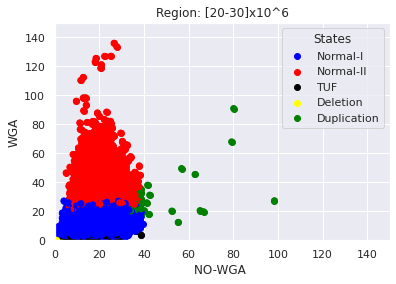

HMM labels color:  {'blue': [1, 152956], 'red': [2, 45769], 'black': [5, 1037], 'yellow': [3, 117], 'green': [0, 119]}
State:  Duplication
WGA mean/var:  26.225126050420176 79.77326027822893
NO-WGA mean/var:  36.403109243697486 110.04973234941039
State:  Normal-I
WGA mean/var:  16.16268848557755 24.54506662988677
NO-WGA mean/var:  18.638535591934936 21.332851427124382
State:  Normal-II
WGA mean/var:  30.629830015949658 53.44580185447626
NO-WGA mean/var:  19.62899954117416 18.874029257554028
State:  Deletion
WGA mean/var:  1.0813675213675213 1.5793930016801812
NO-WGA mean/var:  1.6135042735042735 2.191477463656951
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.997907425265188 2.1490985140914423
NO-WGA mean/var:  14.78029893924783 28.153492388938123
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [15]:
# load the region we want to use for prediction
region_name = "region_0_REGION_2_CHR_13_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr=chr,
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [20-30]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r3"></a>  Region 3

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_3_CHR_13_MEAN_CUTOFF.txt
Sequence length:  199998
Observation length:  199998
Done. Execution time 0.6977121420004551 secs
Log-probability of ML Viterbi path:  -1347779.556077647
Viterbi path length:  199999
There should be 0 gaps
Length of path  199998
Length of TUF+DELETION+TUF state:  197
Length of WGA Observations:  199998
Encountered gaps:  0
{'Duplication': 436, 'Normal-I': 151532, 'Normal-II': 47338, 'Deletion': 191, 'Single-Deletion': 0, 'TUF': 501, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


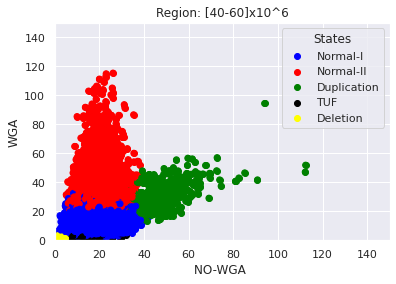

HMM labels color:  {'blue': [1, 151532], 'red': [2, 47338], 'green': [0, 436], 'black': [5, 501], 'yellow': [3, 191]}
State:  Duplication
WGA mean/var:  30.00410550458716 89.55282374116236
NO-WGA mean/var:  44.86727064220184 145.64663544051427
State:  Normal-I
WGA mean/var:  16.221761146160546 24.02598846912153
NO-WGA mean/var:  19.17800233614022 21.656882897257166
State:  Normal-II
WGA mean/var:  31.105622121762643 61.86551639546483
NO-WGA mean/var:  19.81206176855803 18.892873749870905
State:  Deletion
WGA mean/var:  0.9297382198952878 1.4980245388010198
NO-WGA mean/var:  1.081413612565445 1.9099953838984676
State:  Single-Deletion
State:  TUF
WGA mean/var:  3.2172255489021953 1.6026974920418644
NO-WGA mean/var:  13.649540918163673 28.22636765351533
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [16]:
# load the region we want to use for prediction
region_name = "region_0_REGION_3_CHR_13_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr=chr,
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [40-60]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r4"></a>  Region 4

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_4_CHR_13_MEAN_CUTOFF.txt
Sequence length:  199960
Observation length:  199960
Done. Execution time 0.509968520998882 secs
Log-probability of ML Viterbi path:  -1330082.5750643183
Viterbi path length:  199961
There should be 0 gaps
Length of path  199960
Length of TUF+DELETION+TUF state:  45
Length of WGA Observations:  199960
Encountered gaps:  0
{'Duplication': 251, 'Normal-I': 167888, 'Normal-II': 31490, 'Deletion': 29, 'Single-Deletion': 0, 'TUF': 302, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


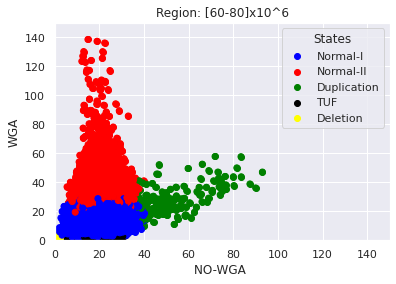

HMM labels color:  {'blue': [1, 167888], 'red': [2, 31490], 'green': [0, 251], 'black': [5, 302], 'yellow': [3, 29]}
State:  Duplication
WGA mean/var:  25.593625498007967 76.39681514261679
NO-WGA mean/var:  44.66290836653386 203.14857281630452
State:  Normal-I
WGA mean/var:  15.742114028399886 22.904611879878495
NO-WGA mean/var:  20.04764884923282 20.811288691450596
State:  Normal-II
WGA mean/var:  30.009952683391553 53.91710256047947
NO-WGA mean/var:  20.671225150841536 18.306212058865693
State:  Deletion
WGA mean/var:  1.6562068965517243 1.8720511296076099
NO-WGA mean/var:  1.6206896551724141 1.0344133174791914
State:  Single-Deletion
State:  TUF
WGA mean/var:  3.2146357615894043 1.4501414236217711
NO-WGA mean/var:  14.943874172185428 39.30221446098855
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [17]:
# load the region we want to use for prediction
region_name = "region_0_REGION_4_CHR_13_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr=chr,
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs,
                          title="Region: [60-80]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r5"></a>  Region 5

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_5_CHR_13_MEAN_CUTOFF.txt
Sequence length:  200000
Observation length:  200000
Done. Execution time 0.5580439470013516 secs
Log-probability of ML Viterbi path:  -1323052.3257856758
Viterbi path length:  200001
There should be 501 gaps
Length of path  200000
Length of TUF+DELETION+TUF state:  386
Length of WGA Observations:  199499
Encountered gaps:  501
{'Duplication': 81, 'Normal-I': 166484, 'Normal-II': 31721, 'Deletion': 86, 'Single-Deletion': 0, 'TUF': 1127, 'GAP_STATE': 501, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


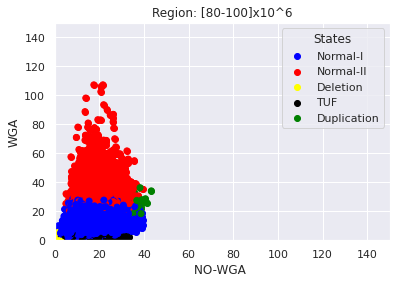

HMM labels color:  {'blue': [1, 166484], 'red': [2, 31721], 'yellow': [3, 86], 'black': [5, 1127], 'green': [0, 81]}
State:  Duplication
WGA mean/var:  24.79283950617284 17.33591662856272
NO-WGA mean/var:  34.262962962962966 11.51764060356653
State:  Normal-I
WGA mean/var:  15.740079106700945 23.354668524652006
NO-WGA mean/var:  19.698642632325026 21.67220498223284
State:  Normal-II
WGA mean/var:  30.042051637716337 44.256535149567085
NO-WGA mean/var:  20.460916742851737 18.855602261628505
State:  Deletion
WGA mean/var:  1.8563953488372098 1.694216076257436
NO-WGA mean/var:  2.360348837209302 1.0775196457544618
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.7212866015971606 2.1824461707432867
NO-WGA mean/var:  15.977613132209406 33.66581941377608
State:  GAP_STATE
WGA mean/var:  -999.0 0.0
NO-WGA mean/var:  -999.0 0.0
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [18]:
# load the region we want to use for prediction
region_name = "region_0_REGION_5_CHR_13_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr=chr,
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs,
                          title="Region: [80-100]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r6"></a>  Region 6 

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_6_CHR_13_MEAN_CUTOFF.txt
Sequence length:  100000
Observation length:  100000
Done. Execution time 0.24397958500048844 secs
Log-probability of ML Viterbi path:  -668976.5550811122
Viterbi path length:  100001
There should be 0 gaps
Length of path  100000
Length of TUF+DELETION+TUF state:  177
Length of WGA Observations:  100000
Encountered gaps:  0
{'Duplication': 36, 'Normal-I': 77409, 'Normal-II': 21654, 'Deletion': 51, 'Single-Deletion': 0, 'TUF': 850, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


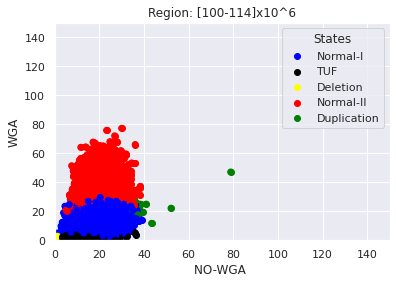

HMM labels color:  {'blue': [1, 77409], 'black': [5, 850], 'yellow': [3, 51], 'red': [2, 21654], 'green': [0, 36]}
State:  Duplication
WGA mean/var:  23.61277777777778 30.81336450617285
NO-WGA mean/var:  36.15722222222222 70.38252561728395
State:  Normal-I
WGA mean/var:  16.049707527548478 24.374424983896237
NO-WGA mean/var:  19.30198982030513 20.71331719061063
State:  Normal-II
WGA mean/var:  30.47387226378498 45.87637471186301
NO-WGA mean/var:  20.203854715064193 18.460753271771203
State:  Deletion
WGA mean/var:  0.7905882352941177 0.7834133794694349
NO-WGA mean/var:  1.3841176470588237 1.6942006920415227
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.644294117647059 2.300012501730104
NO-WGA mean/var:  16.463482352941174 31.711088579100345
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [19]:
# load the region we want to use for prediction
region_name = "region_0_REGION_6_CHR_13_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr=chr,
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [100-114]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))